# Univariate Feature Selection
(by Tevfik Aytekin)

In feature selection we try to find relevant features, that is, features which have an influence on the output. We will also try to quantify the influence of a feature. There are several ways we can find the relevance of features, in this notebook we will look at univariate filter methods. In other words, we will try to find the relevance of a single feature (independent of the others) on the output. 


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.utils import resample
from scipy.stats import chisquare
from sklearn.feature_selection import chi2, SelectKBest, f_classif, f_regression
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from scipy.stats import chi2
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_classif
from sklearn import feature_selection



### Univariate Feature Selection
We will look at the pairwise relationships between the output variable and each one of the input variables. Our aim is to understand whether these pairs of variables are independent of each other or there is some kind of relationship between them. Different from visualizations, we will generate a numerical value for measuring the strength of the relationship.

Notes:
- If there is a significant relationship then that is something valuable. 
- If there is no significant relationship then it does not show that the input variable and the output variable are independent of each other because:
    - Maybe there is another relationship we have not look at yet (for example even if there is no linear correlation may there is another type of correlation.
    - Or may be the input variable togother with another variable (may be their product or ratio) has some significant relationship with the output variable.
    
We will use the following two datasets for illustration.
#### Example Datasets

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#bank = pd.read_csv("drive/MyDrive/PycharmProjects/datasets/bank/bank-full.csv", delimiter = ";")
bank = pd.read_csv("../../datasets/bank/bank-full.csv", delimiter = ";")
bank.shape

(45211, 17)

In [4]:
# list random rows from the dataset
bank.iloc[np.random.randint(1,bank.shape[0],10),:] 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
16031,30,management,single,tertiary,no,77,no,no,cellular,22,jul,267,1,-1,0,unknown,no
27223,33,blue-collar,divorced,secondary,no,86,no,yes,cellular,21,nov,183,3,186,1,failure,no
28665,30,technician,single,tertiary,no,6683,no,no,cellular,30,jan,180,1,-1,0,unknown,no
44239,29,admin.,single,secondary,no,1277,no,no,cellular,20,jul,165,2,481,1,success,yes
10852,39,self-employed,divorced,tertiary,no,1415,no,no,unknown,17,jun,134,1,-1,0,unknown,no
16117,57,entrepreneur,married,unknown,no,975,yes,yes,cellular,22,jul,236,4,-1,0,unknown,no
7620,36,management,married,tertiary,no,722,yes,no,unknown,30,may,312,1,-1,0,unknown,no
23487,40,technician,single,secondary,no,872,yes,no,cellular,28,aug,71,4,-1,0,unknown,no
3747,37,management,single,tertiary,no,499,yes,no,unknown,16,may,537,1,-1,0,unknown,no
34576,33,management,single,tertiary,no,12686,yes,no,cellular,5,may,470,2,166,2,failure,no


In [5]:
# load train.csv file from Kaggle "House Prices: Advanced Regression Techniques" dataset 
#house = pd.read_csv("drive/MyDrive/PycharmProjects/datasets/house_prices/train.csv")
house = pd.read_csv("../../datasets/house_prices/train.csv")
# print first 5 examples
house.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Case 1: Numerical Input vs. Numeric Output

For this type of analysis a common technique is to look at the correlation between the variables. There are three commonly used correlation measures: Pearson, Spearman, and Kendall. We will look at each in turn.


### Pearson correlation

Pearson correlation is a measure of linear relationship between two random variables X and Y. It is a scaled version of covariance (between -1 and 1); note that the two parameters always have the same sign (positive, negative, or 0). When the sign is positive, the variables are said to be positively correlated; when the sign is negative, the variables are said to be negatively correlated; and when the sign is 0, the variables are said to be uncorrelated. For basic statistical concepts like variance, covariance, and standard deviation check this [notebook](stats.ipynb).

$$pcorr(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

PearsonRResult(statistic=0.9874100874179735, pvalue=7.282637065766433e-07)

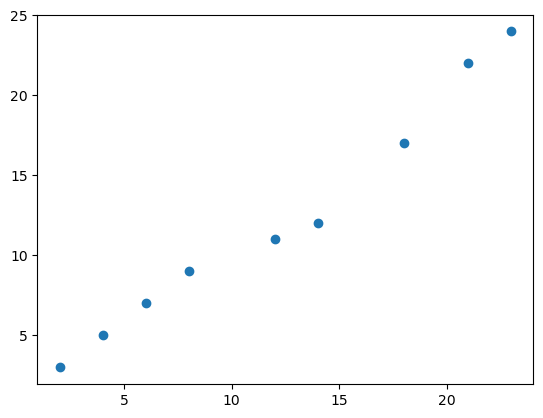

In [6]:
# Example
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 12, 17, 22, 24]

plt.plot(X,Y, "o")

# returns correlation and p-value
stats.pearsonr(X,Y)

### A note on p-value

p-value is an important statistical concept used in hypothesis testing. Technically, the p-value is the probability of observing a test statistic that is as extreme or more extreme than the observed test statistic under the null hypothesis. Intiutively, it means how likely it is to observe the sample by chance. If the p-value is small (typically less then 0.05) then we can reject the null hypothesis, that is, we can conclude that its very unlikely to observe the sample by chance.

For Pearson correlation the null hypothesis is that the samples come from a uncorrelated bivariate normal distribution. 

p-values are important when the sample sizes are small. Check out the sample below, the correlation is high but p-value > 0.05 which implies that the samples might come from uncorrelated populations. As a rule of thumb, you should ignore correlations which are not statistically significant (p > 0.05) even if the correlation is high.

PearsonRResult(statistic=0.8944271909999159, pvalue=0.10557280900008426)

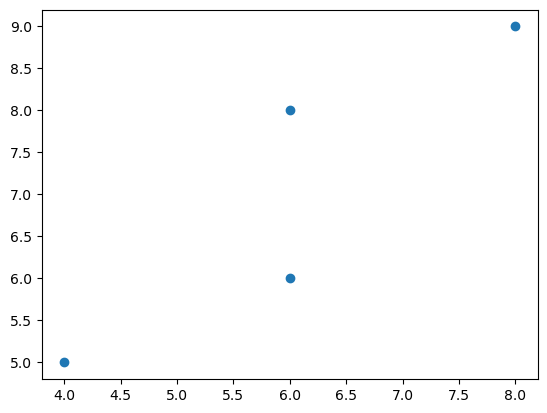

In [7]:
# Example
X = [6, 4, 6, 8] 
Y = [6, 5, 8, 9] 
plt.plot(X,Y, "o")

# returns correlation and p-value
stats.pearsonr(X,Y)

Below are some example datases with various degrees of Pearson correlation.

Question: Note that there is no correlation coefficient value for the dataset in the middle position. Why is that? Hint: Check the definition of correlation.

[image source](http://commons.wikimedia.org/wiki/File:Correlation_examples2.svg)

<img src="images/cor1.png" alt="drawing" width="500" align="left">


### <center>Anscombe's Quartet</center>

For all four datasets below the Pearson correlation coefficient is: +0.816.

<img src="images/cor2.png" alt="drawing" width="500" align="left">  


[image source](http://commons.wikimedia.org/wiki/File:Anscombe%27s_quartet_3.svg)  


#### Outlier Problem

Outliers might dratically influence the correlation values, so one should be careful with outliers in the evaluation of correlation results.

PearsonRResult(statistic=0.0020896678072882535, pvalue=0.9957429791908512)

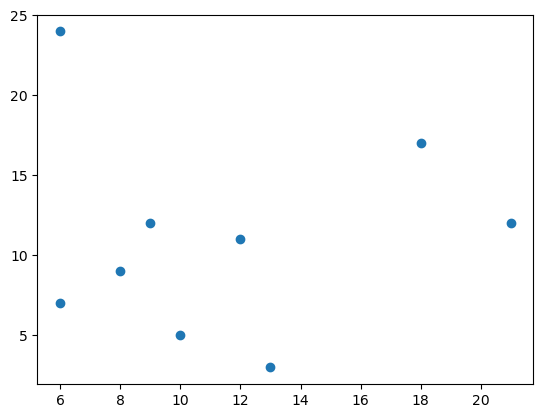

In [8]:
# Example
X = [13, 10, 6, 8, 12, 9, 18, 21, 6]
Y = [3, 5, 7, 9, 11, 12, 17, 12, 24]
plt.plot(X,Y, "o")
stats.pearsonr(X,Y)

PearsonRResult(statistic=0.9632125532618062, pvalue=7.664333701501093e-06)

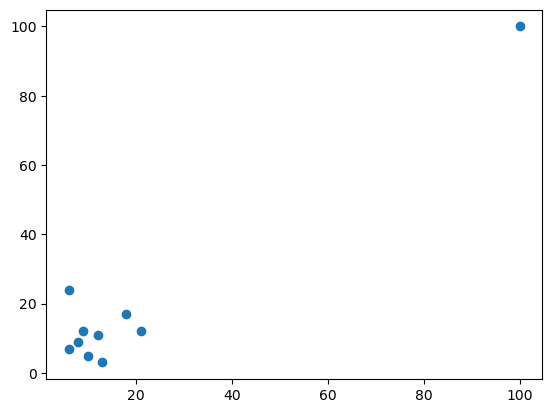

In [9]:
# After adding a single outlier
X = [13, 10, 6, 8, 12, 9, 18, 21, 6, 100]
Y = [3, 5, 7, 9, 11, 12, 17, 12, 24, 100]
plt.plot(X,Y, "o")
stats.pearsonr(X,Y)

### Spearman rank correlation
Spearman rank correlation is the Pearson correlation between the rank values of two variables.

<img src="images/spearman.png" width="400" align="left">

[image source](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Spearman_fig1.svg/600px-Spearman_fig1.svg.png)

SignificanceResult(statistic=1.0, pvalue=0.0)
Pearson: PearsonRResult(statistic=0.8140522903309356, pvalue=0.00039463198897921417)


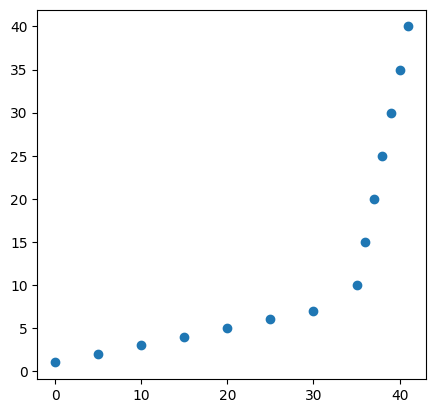

In [20]:
# Example
X = [0, 5, 41, 15, 20, 25, 30, 35, 36, 37, 38, 39, 40, 10]
Y = [1, 2, 40, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 3]

plt.plot(X,Y, "o")
plt.gca().set_aspect('equal')
print(stats.spearmanr(X,Y))
print("Pearson:",stats.pearsonr(X,Y))

In [21]:
print(stats.rankdata(X))
print(stats.rankdata(Y))

[ 1.  2. 14.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  3.]
[ 1.  2. 14.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  3.]


SignificanceResult(statistic=0.9340659340659341, pvalue=1.0279787693084366e-06)

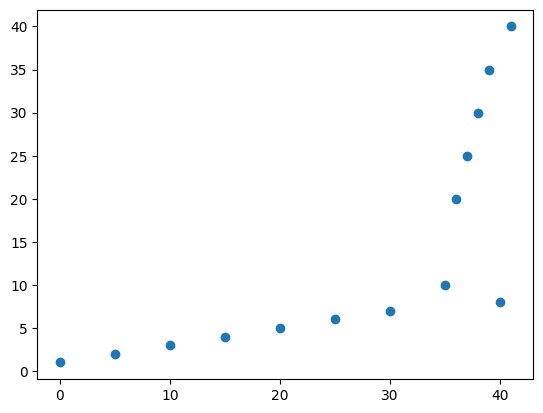

In [22]:
# Let us change the example a little
X = [0, 5, 10, 15, 20, 25, 30, 35, 36, 37, 38, 39, 40, 41]
Y = [1, 2, 3, 4, 5, 6, 7, 10, 20, 25, 30, 35, 8, 40]

plt.plot(X,Y, "o")
stats.spearmanr(X,Y)

In [23]:
X_ranks = stats.rankdata(X)
Y_ranks = stats.rankdata(Y)
print(X_ranks); print(Y_ranks)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 1.  2.  3.  4.  5.  6.  7.  9. 10. 11. 12. 13.  8. 14.]


In [24]:
stats.pearsonr(X_ranks,Y_ranks)

PearsonRResult(statistic=0.9340659340659341, pvalue=1.0279787693084372e-06)

### Kendall Rank Correlation

In [25]:
def my_kendall_tau(x,y):
    concordant = 0
    discordant = 0
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if ((x[i]-x[j]) * (y[i]-y[j])) > 0:
                concordant += 1
            else:
                discordant += 1
    return (concordant-discordant)/(concordant+discordant)

In [26]:
X = [0, 5, 41, 15, 20, 25, 30, 35, 36, 37, 38, 39, 40, 10]
Y = [1, 2, 40, 4, 5, 6, 7, 10, 15, 20, 25, 30, 35, 3]
X_ranks = stats.rankdata(X)
Y_ranks = stats.rankdata(Y)
print(X_ranks)
print(Y_ranks)

[ 1.  2. 14.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  3.]
[ 1.  2. 14.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  3.]


In [27]:
my_kendall_tau(X_ranks,Y_ranks)

1.0

In [28]:
my_kendall_tau(X,Y)

1.0

SignificanceResult(statistic=0.8176920377625482, pvalue=4.966324030587148e-05)

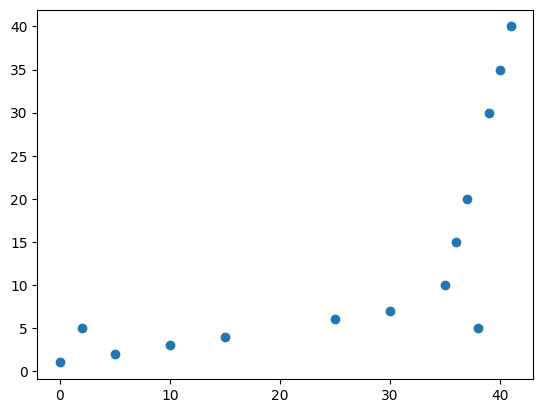

In [29]:
X = [0, 5, 10, 15, 2, 25, 30, 35, 36, 37, 38, 39, 40, 41]
Y = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 5, 30, 35, 40]
plt.plot(X,Y, "o")
stats.kendalltau(X,Y)

In [30]:
my_kendall_tau(X,Y)

0.8021978021978022

You can get all pairwise correlations easily as follows: (Note that you can set the method parameter to pearson, kendall, and spearman.

In [ ]:
plt.figure(figsize=(12,10));
sns.heatmap(house.corr(numeric_only=True));

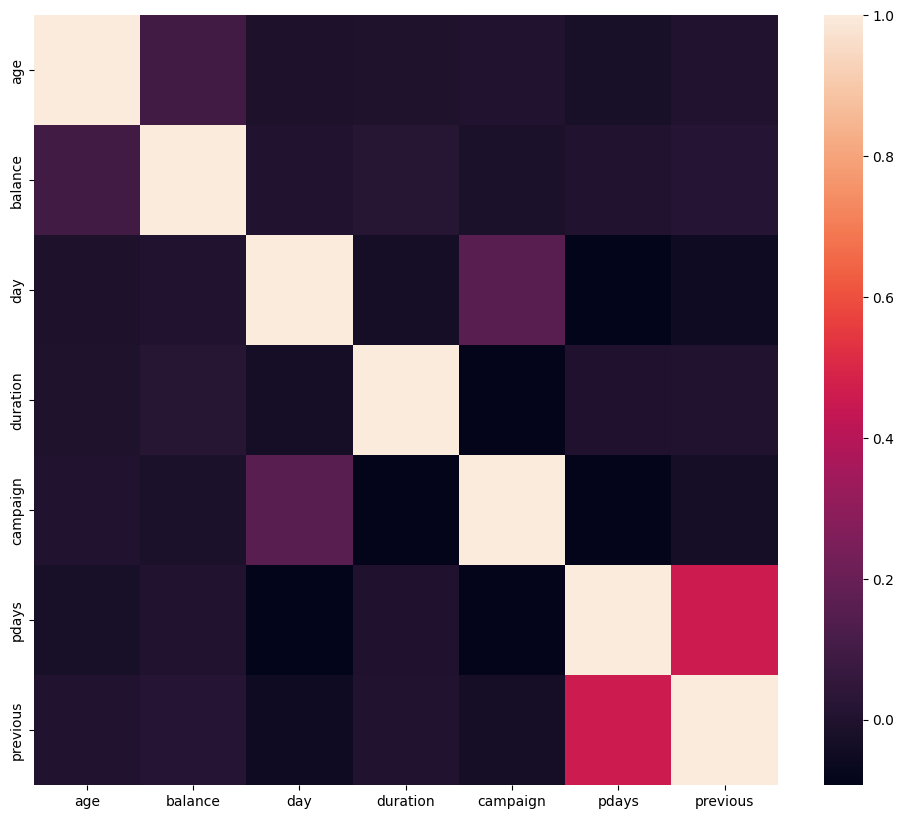

In [32]:
plt.figure(figsize=(12,10));
sns.heatmap(bank.corr(numeric_only=True));

# Case 2: Numerical Input vs. Categorical Output


Now we will try to see if a numerical feature is relevant for a categorical class variable. One thing we can do is to look at the distribution of the numerical variable grouped by each value of the categorical variable. If the categorical and numerical variables are independent then we expect to see a similar distribution of the values of the numerical variable for each value of the categorical variable (i.e., the grouping of the numerical variable by the values of the categorical variable should not create any difference). But if the distributions are not similar then we may say that the numerical variable is relevant and also as the dissimilarity of the distributions increase it is reasonable to assume that the relevancy also increases. Of course we need some formula to measure similarity of distributions. Note that there can be two or more distributions. So our measure should work for two or more distributions. One such measure is Anova F-value.

F-statistic is a way of measuring the difference between sample distributions which is defined below. Further below you will find the implementation.

$$ F = \frac{Variation\: between\: sample\: means}{Variation\: within\: the\: samples} $$


**Look at the following figures and try to answer this question: are these groups come from the same population or not? How can we measure this probability, that is, the probability of coming form the same distribution?**

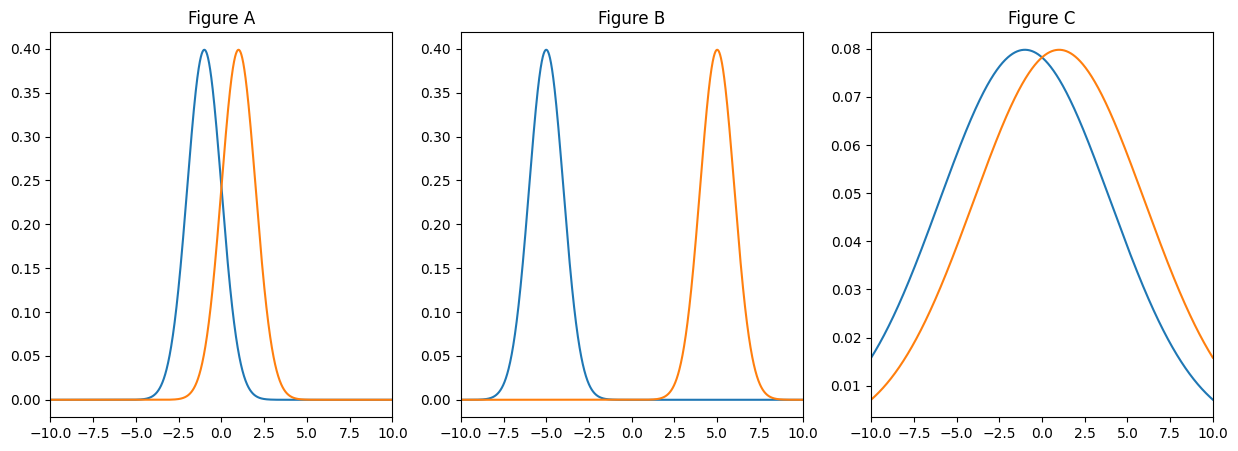

In [33]:
f, ax = plt.subplots(1,3)
ax[0].set_xlim(-10,10)
f.set_size_inches(12,10)

x = np.arange(-10, 10, 0.01)
sns.lineplot(x=x, y=stats.norm.pdf(x,-1,1), ax= ax[0])
sns.lineplot(x=x, y=stats.norm.pdf(x,1,1), ax= ax[0])

ax[1].set_xlim(-10,10)
sns.lineplot(x=x, y=stats.norm.pdf(x,-5,1), ax= ax[1])
sns.lineplot(x=x, y=stats.norm.pdf(x,5,1), ax= ax[1])

ax[2].set_xlim(-10,10)
sns.lineplot(x=x, y=stats.norm.pdf(x,-1,5), ax= ax[2])
sns.lineplot(x=x, y=stats.norm.pdf(x,1,5), ax= ax[2])

ax[0].title.set_text("Figure A")
ax[1].title.set_text("Figure B")
ax[2].title.set_text("Figure C")
f.set_figwidth(15)
f.set_figheight(5)


# Mean = 0, Std = 2. You can play wth these parameters.


NameError: ignored

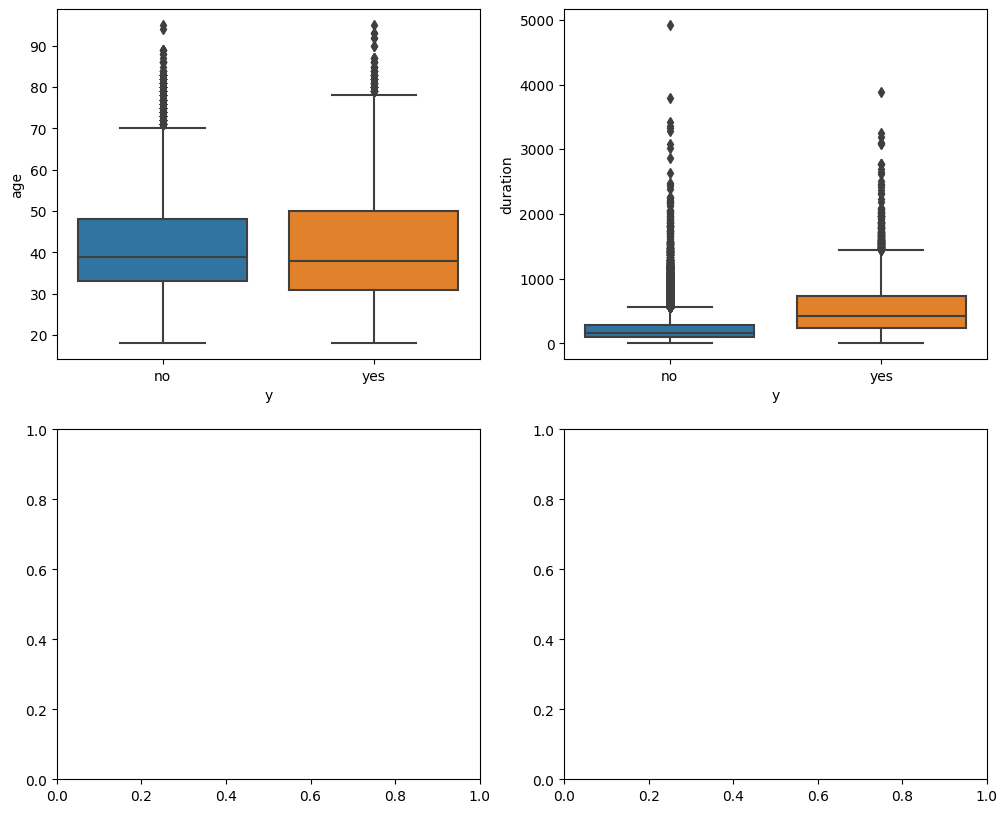

In [34]:
f, ax = plt.subplots(2,2)
f.set_size_inches(12,10)
sns.boxplot(y="age", x="y", data= bank, ax = ax[0,0]);
sns.boxplot(y="duration", x="y", data= bank, ax = ax[0,1]);
sns.boxplot(x="MSZoning", y="SalePrice", data= house, ax = ax[1,0]);
sns.boxplot(x="SaleCondition", y="SalePrice", data= house, ax = ax[1,1]);


In [ ]:
bank["age"].hist(by=bank["y"])

Below is the result of one-way anova test. As can be seen the result is statistically significant, so smaller age indeeds affects the result in the positive way, however, what is the size of this affect?


In [ ]:
group1 = bank[bank["y"]=="yes"].age
group2 = bank[bank["y"]=="no"].age
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)


Let us calculate the f-value from scratch.

In [ ]:
def my_f_statistic(*groups):
    
    merged_groups = np.concatenate(groups)
    grand_mean = np.mean(merged_groups)
    group_means = [np.mean(g) for g in groups]
    ss_within = 0
    ss_between = 0
    for i in range(len(groups)):
        ss_within += np.sum((groups[i] - group_means[i])**2)
        ss_between += groups[i].size * (group_means[i] - grand_mean)**2
        
    df1 = len(groups) - 1
    df2 = merged_groups.size - len(groups)
    f_stat = (ss_between / df1) / (ss_within / df2)
    
    #print(ss_between / df1)
    #print(ss_within / df2)
    #print(ss_total," ",ss_within," ", ss_between)
    #print(ss_within + ss_between)
    #print(f_statistic)
    
    return f_stat

An example step by step

In [ ]:
groups = [[1,2,3,4,5],[3,4,5,6,7]]
group1 = [1,2,3,4,5]
group2 = [3,4,5,6,7]
merged_groups = np.concatenate(groups)
grand_mean = np.mean(merged_groups)
print("grand mean",grand_mean)
group_means = [np.mean(g) for g in groups]
print("group means", group_means)

In [ ]:
i=0
(groups[i] - group_means[i])**2

In [ ]:
group1 = bank[bank["y"]=="yes"].age.values
group2 = bank[bank["y"]=="no"].age.values
my_f_statistic(group1, group2)


In [ ]:
sns.boxplot(y="balance", x="y", data= bank);

In [ ]:
bank2 = bank[(bank.balance < 5000)]
sns.boxplot(y="balance", x="y", data= bank2);

In [35]:
group1 = bank[bank["y"]=="yes"].balance
group2 = bank[bank["y"]=="no"].balance
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)

126.57227551143087 2.5211136918594683e-29


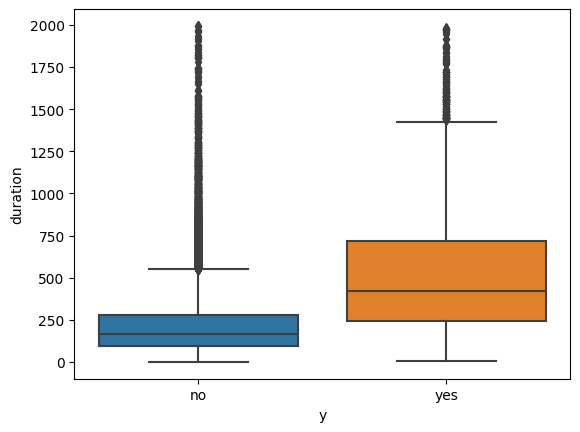

In [36]:
bank2 = bank[(bank.duration < 2000)]
sns.boxplot(y="duration", x="y", data= bank2);

In [37]:
group1 = bank[bank["y"]=="yes"].duration
group2 = bank[bank["y"]=="no"].duration
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)

8333.761148332413 0.0


### SelectKBest

We can use SelectKBest to find features with the highest scores.

In [38]:
X = bank.loc[:,'age':'poutcome']
X = bank.select_dtypes(include=np.number) # select numeric columns

y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,-1])
selector = SelectKBest(f_classif, k=7)
selector.fit(X, y)

SelectKBest(k=7)

In [39]:
sorted_idx = np.argsort(selector.scores_)[::-1]
sorted_vals = np.sort(selector.scores_)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals, "p-values":selector.pvalues_[sorted_idx]}
df = pd.DataFrame(d)
df

,features,values,p-values
0,duration,8333.761148,0.000000e+00
1,pdays,490.696563,3.790553e-108
2,previous,396.443989,7.801830e-88
3,campaign,243.358404,1.012347e-54
4,balance,126.572276,2.521114e-29
5,day,36.359010,1.653880e-09
6,age,28.625233,8.825644e-08


### More than two groups

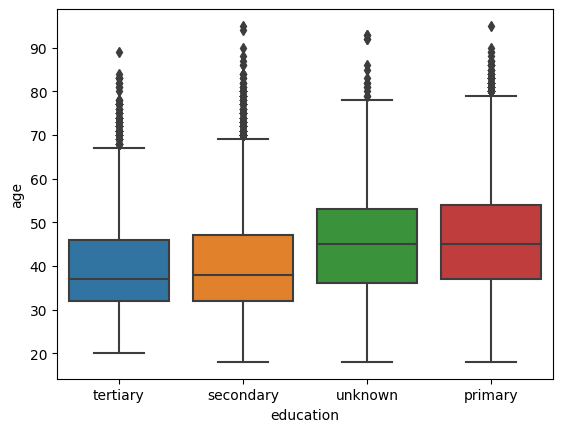

In [40]:
sns.boxplot(y="age", x="education", data= bank);

In [41]:
group1 = bank[bank["education"]=="primary"].age
group2 = bank[bank["education"]=="secondary"].age
group3 = bank[bank["education"]=="tertiary"].age
group4 = bank[bank["education"]=="unknown"].age

fvalue, pvalue = stats.f_oneway(group1, group2, group3, group4)
print(fvalue, pvalue)

731.7577454812724 0.0


In [ ]:
my_f_statistic(group1,group2,group3,group4)

In [ ]:
sns.boxplot(y="age", x="marital", data= bank);

In [ ]:
group1 = bank[bank["marital"]=="single"].age
group2 = bank[bank["marital"]=="married"].age
group3 = bank[bank["marital"]=="divorced"].age


fvalue, pvalue = stats.f_oneway(group1, group2, group3)
print(fvalue, pvalue)

# Case 3: Categorical Input vs. Numerical Output

Actually this case is essentially the same as case 3, so we can use F-value.


# Case 4: Categorical Input vs. Categorical Output

When the input feature is categorical and the class is also categorical, the most common measures used are chi-square test and mutual information.


### Chi Square Test

You can read this [part](https://online.stat.psu.edu/stat500/lesson/8/8.1) first as a general introduction.

As an example let us consider if there is a relationship between marital status and the class y for the banking dataset. Chi-square test relies on a contingency table. Let us first remember the banking dataset: 

In [43]:
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [44]:
def calc_contingency_table(df, a1, a2):
    group1 = np.unique(df[a1])
    group2 = np.unique(df[a2])
    con_table = np.zeros((len(group1),len(group2)))
    for i in range(len(group1)):
        for j in range(len(group2)):
            con_table[i][j] = sum((df[a1] == group1[i]) & (df[a2] == group2[j]))
    return con_table, group1, group2

In [45]:
con_table,g1,g2 = calc_contingency_table(bank,"y","marital")

In [46]:
pd.DataFrame(con_table, index=g1, columns=g2)

,divorced,married,single
no,4585.0,24459.0,10878.0
yes,622.0,2755.0,1912.0


Marital status M and y are two discrete random variables denoted with the letters M and Y respectively. If we assume that they are independent random variables what will be 

$$ P(M = single, Y = yes) $$

Since we are assuming that they are independent variables:

$$ P(M = single, Y = yes) = P(M = single) * P(Y = yes) $$

So, let us calculate these probabilities.

In [47]:
marginals_col = con_table.sum(axis=0)
marginals_col

array([ 5207., 27214., 12790.])

In [48]:
marginals_row = con_table.sum(axis=1)
marginals_row

array([39922.,  5289.])

In [49]:
total = con_table.sum()
total

45211.0

The above calculations show that there are a total of 45211 people and 12790 of them are single. So $P(M = single) = 12790/45211$ and similarly $P(Y = yes) = 5289/45211$. If you multiply these values you will get their joint probability.

How can we calculate the "expected count" in each cell of the contingency table given the independence assumption. As an example the expected count of the number of individuals who are single and subscribed a term deposit (Y = yes) can be calculated as:

$$ P(M = single, Y = yes)*total = (\#singles / total) * (\#yes / total) * total = \#singles * \#yes / total$$ 

In [50]:
def my_chi2_contingency(con_table):
    con_table = con_table.astype(float)
    expected_table = con_table.copy()
    marginals_col = con_table.sum(axis=0)
    marginals_row = con_table.sum(axis=1)
    total = con_table.sum()
    for i in range(con_table.shape[0]):
        for j in range(con_table.shape[1]):
            expected = (marginals_row[i]) * (marginals_col[j]) / total
            expected_table[i,j] = expected
            con_table[i][j] = ((con_table[i][j] - expected)**2) / expected
    return con_table.sum(), expected_table

In [51]:
chi2_stat, expected_table = my_chi2_contingency(con_table)
print(chi2_stat)
print(expected_table)

196.4959456560396
[[ 4597.86012254 24030.37552808 11293.76434938]
 [  609.13987746  3183.62447192  1496.23565062]]


### Using statsmodels package

In [52]:
stats.chi2_contingency(con_table)

Chi2ContingencyResult(statistic=196.4959456560396, pvalue=2.1450999986791486e-43, dof=2, expected_freq=array([[ 4597.86012254, 24030.37552808, 11293.76434938],
       [  609.13987746,  3183.62447192,  1496.23565062]]))

### Using sklearn package

In [53]:
le = LabelEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=object) # select string columns
X = X.apply(LabelEncoder().fit_transform)
X

,job,marital,education,default,housing,loan,contact,month,poutcome
0,4,1,2,0,1,0,2,8,3
1,9,2,1,0,1,0,2,8,3
2,2,1,1,0,1,1,2,8,3
3,1,1,3,0,1,0,2,8,3
4,11,2,3,0,0,0,2,8,3
...,...,...,...,...,...,...,...,...,...
45206,9,1,2,0,0,0,0,9,3
45207,5,0,0,0,0,0,0,9,3
45208,5,1,1,0,0,0,0,9,2
45209,1,1,1,0,0,0,1,9,3


In [54]:
le = LabelEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=object) # select string columns
X = X.apply(LabelEncoder().fit_transform)
y = le.fit_transform(bank.loc[:,'y'])
chi2, pval=feature_selection.chi2(X, y)

In [55]:
sorted_idx = np.argsort(chi2)[::-1]
sorted_vals = np.sort(chi2)[::-1]

d = {"features":X.columns[sorted_idx], "values (sklearn)":sorted_vals, "p-values":pval[sorted_idx]}
df1 = pd.DataFrame(d)
df1

,features,values (sklearn),p-values
0,contact,1253.814109,1.230845e-274
1,housing,388.949715,1.401285e-86
2,job,182.452260,1.412576e-41
3,loan,176.516137,2.793375e-40
4,poutcome,104.677479,1.437254e-24
5,education,90.617723,1.742922e-21
6,month,44.321905,2.785815e-11
7,marital,29.766067,4.874498e-08
8,default,22.313875,2.315277e-06


#### Some notes on chi2 test

- **Note 1**: The range of the chi2 statistic is between 0 and infinity which makes it difficult to interpret the magnitude of the dependency. For example check the following two cases:

In [56]:
con_table = np.array([[10, 20, 20],[20, 10, 20]])
print(con_table)
print(stats.chi2_contingency(con_table));

[[10 20 20]
 [20 10 20]]
Chi2ContingencyResult(statistic=6.666666666666667, pvalue=0.035673993347252395, dof=2, expected_freq=array([[15., 15., 20.],
       [15., 15., 20.]]))


In [57]:
con_table = 10*con_table
print(con_table)
print(stats.chi2_contingency(con_table))

[[100 200 200]
 [200 100 200]]
Chi2ContingencyResult(statistic=66.66666666666667, pvalue=3.3382377953650016e-15, dof=2, expected_freq=array([[150., 150., 200.],
       [150., 150., 200.]]))


Even though the ratios of the numbers are the same, the chi2 value in the second case is larger. This makes the p-value of the second case much smaller which means that the second set of variables is much more unlikely to be independent. However, with respect to feature selection this might create a difficulty. Within the same dataset this is not a problem since the number of cases are the same for all the features but we should be careful in interpreting the strength of dependency by looking at the chi2 values which comes from two different datasets. For a possible technique for normalizing the chi2 value one can check [Cramer's V](https://www.wikiwand.com/en/Cram%C3%A9r%27s_V)

- **Note 2**: InPython's implementation of chi2 test there is a difference between chi2 values as calculated in stats.chi2_contingency and feature_selection.chi2

In [58]:
X = bank.select_dtypes(include=['object'])
y = X.y
X = X.drop(labels = ["y"], axis = 1)

In [59]:
scores = []
for i in range(X.shape[1]):
    result = stats.chi2_contingency(pd.crosstab(y,X.iloc[:,i]))
    scores.append(result[0])

In [60]:
scores

[836.1054877471965,
 196.4959456560396,
 238.92350616407606,
 22.20224995571685,
 874.822448867983,
 209.61698034978633,
 1035.7142253562922,
 3061.8389384452685,
 4391.506588768661]

In [61]:
sorted_idx = np.argsort(scores)[::-1]
sorted_vals = np.sort(scores)[::-1]

d = {"features":X.columns[sorted_idx], "values (SM)":sorted_vals, "p-values":pval[sorted_idx]}
df2 = pd.DataFrame(d)
pd.concat([df1, df2], axis=1)

,features,values (sklearn),p-values,features,values (SM),p-values
0,contact,1253.814109,1.230845e-274,poutcome,4391.506589,1.437254e-24
1,housing,388.949715,1.401285e-86,month,3061.838938,2.785815e-11
2,job,182.452260,1.412576e-41,contact,1035.714225,1.230845e-274
3,loan,176.516137,2.793375e-40,housing,874.822449,1.401285e-86
4,poutcome,104.677479,1.437254e-24,job,836.105488,1.412576e-41
5,education,90.617723,1.742922e-21,education,238.923506,1.742922e-21
6,month,44.321905,2.785815e-11,loan,209.616980,2.793375e-40
7,marital,29.766067,4.874498e-08,marital,196.495946,4.874498e-08
8,default,22.313875,2.315277e-06,default,22.202250,2.315277e-06


### Mutual Information

#### Entropy

Given a discrete random variable $X$ with outcomes $\mathcal{X}=\{x_{1},...,x_{n}\}$ which occur with probability $p(x_{1}),...,p(x_{n})$ can we quantify the uncertainity in $X$? In other words, how uncertain we are of the outcome of $X$?

Let us look at an example. Assume that we gave the following coins with the given probabilities of heads and tails. When we flip the coins how uncertain of the outcome in each case.

Coin $A$: $P(H) = 0.5, P(T) = 0.5$ 

Coin $B$: $P(H) = 0.1, P(T) = 0.9$ 

Coin $C$: $P(H) = 0, P(T) = 1$

Actually for coin $C$ there is no uncertainity, we are 100% sure that the outcome will be $T$, what about coins $A$ and $B$?. For coin $B$ even though we are not 100% sure of the outcome it is less uncertain compared to coin $C$. Now actually what we have done is to order these coins with respect to uncertainity in them which is A, B and then C (in decreasing order of uncertainity). The following famous formula (called the entropy) quantifies this intuition of uncertainity: 


$$
H(X) = -\sum_{x \in \mathcal{X}}p(x)logp(x) 
$$

Note that the above explanation is not a complete reason to choose this particular formula. There can be other formulas we can use to quantify uncertainity. Indeed there are, for example we can use Gini index or variance to quantify similar notions (uncertainity, diversity, impurity, etc.). If you want to learn why this specific formula is used you should consult the paper written by its inventor C. E. Shannon [A Mathematical Theory of Communication](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) especially Section 6. "CHOICE, UNCERTAINTY AND ENTROPY".

In [62]:
# pk[i] is the probability of outcome i
def my_entropy(pk):
    S = 0
    for i in range(len(pk)):
        if pk[i] > 0:
            S = S - pk[i]*np.log2(pk[i])
    return S

Some examples

In [63]:
# Entropy of a coin
pk = [0.5, 0.5]
print("Entropy of a fair coin:", my_entropy(pk))
pk = [0.1, 0.9]
print("Entropy of a biased coin:", my_entropy(pk))
pk = [0, 1]
print("Entropy of a perfect biased coin:", my_entropy(pk))

# Entropy of a dice
pk = [1/6,1/6,1/6,1/6,1/6,1/6]
print("Entropy of a fair dice:", my_entropy(pk))
pk = [2/6,2/6,0/6,0/6,2/6,0/6]
print("Entropy of biased dice:", my_entropy(pk))
pk = [0,0,0,0,0,1]
print("Entropy of a perfect biased dice:", my_entropy(pk))

Entropy of a fair coin: 1.0
Entropy of a biased coin: 0.4689955935892812
Entropy of a perfect biased coin: 0.0
Entropy of a fair dice: 2.584962500721156
Entropy of biased dice: 1.584962500721156
Entropy of a perfect biased dice: 0.0


Shape of the entropy function for a variable with two outcomes

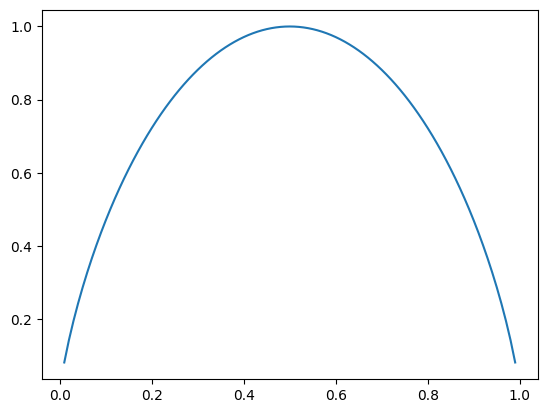

In [64]:
x = np.arange(0.01,1,0.01)
s = []
for i in x:
    s.append(my_entropy([i,1-i]))
plt.plot(x,s)


#### Some facts about entropy

- The range of Entropy:
    $0 ≤ Entropy ≤ log(n)$, where $n$ is number of outcomes
- Minimum entropy, $0$, occurs when one of the probabilities is $1$ and rest are $0$’s.
- Maximum entropy, $log(n)$, occurs when all the probabilities are the same, namely, $1/n$.

#### Joint Entropy

The joint entropy of two discrete random variables is given by 
$$
H(X,Y) = -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(x,y)
$$

where $p(x,y)$ is the joint probability mass function.

#### Conditional Entropy

Conditional entropy quantifies the entropy of a random variable $X$ given the value of another random variable $Y$. For a single value of Y:

$$
H(X|Y=y) = -\sum_{x \in \mathcal{X}}P(X=x|Y=y)logP(X=x|Y=y)
$$

Weighted average over all possible values of $Y$ gives the conditional entropy of $X$ given $Y$.

$$
\begin{aligned}
H(X|Y) &= \sum_{y \in \mathcal{Y}}P(Y=y)H(X|Y=y) \\
&= -\sum_{y \in \mathcal{Y}}P(Y=y)\sum_{x \in \mathcal{X}}P(X=x|Y=y)logP(X=x|Y=y) \\
&= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}P(X=x,Y=y)log(P(X=x|Y=y) \\
&= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)log(p(x|y)) \\
\end{aligned}
$$

#### The chain rule of entropy

For two random variables $X$ and $Y$

$$
H(X,Y)=H(X)+H(Y∣X)
$$

Proof:

$$
\begin{aligned}
H(X,Y) &= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(x,y)\\
&= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)log(p(x)p(y|x)) \\
&= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(x)-\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(y|x) \\
&= -\sum_{x \in \mathcal{X}}p(x)logp(x)-\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(y|x) \\
&= H(X)+H(Y|X)
\end{aligned}
$$

Similary, it can also be proved that
$$
\begin{aligned}
H(X,Y) &= H(Y)+H(X|Y)
\end{aligned}
$$

#### Mutual Information

Mutual information between the random variables $X$ and $Y$ is defined as

$$
\begin{aligned}
I(X;Y) &= H(X) - H(X|Y) \\
&= -\sum_{x \in \mathcal{X}}p(x)logp(x)+\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(x|y) \\
&= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(x)+\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)logp(x|y) \\
&= -\sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)log\frac{p(x|y)}{p(x)} \\
&= \sum_{x \in \mathcal{X}}\sum_{y \in \mathcal{Y}}p(x,y)log\frac{p(x,y)}{p(x)p(y)}
\end{aligned}
$$

Initutively, $H(X)$ is the amount of information in $X$ and $H(X|Y)$ is the information left in $X$ when $Y$ is known.  So, $H(X) - H(X|Y)$ can be interpreted as the information common in both $X$ and $Y$.

Note that it can be shown that I(X;Y) = I(Y;X)



### Mutual information vs. Chi2

As also can be seen in the calculation in the following function, there is a close relationship between MI and chi2. Both compare joint and independent probabilities of two random variables. One might ask so which one is better? There is no best measure here, it is like asking whether MAE or MSE better for accuracy calculation. The answer should be: both measures have different properties, and it is best to use these measures with an understanding about these properties.  

In [65]:
def my_mutual_info(df, a1, a2):
    con_table, g1, g2 = calc_contingency_table(df, a1, a2)
    con_table[0,0]=10
    print(con_table)
    marginals_col = con_table.sum(axis=0)
    marginals_row = con_table.sum(axis=1)
    total = con_table.sum()
    mi = 0
    for i in range(con_table.shape[0]):
        for j in range(con_table.shape[1]):
            # Calculate joint probability.
            p = con_table[i][j] / total
            m = (marginals_row[i] / total)*(marginals_col[j] / total)
            print(p,m)
            if (p > 0):
                print(p*np.log(p / m))
                mi += p*np.log(p / m)
    return mi

In [66]:
x = np.array([1,2,3,4,5,6,8,7,9,10,6,6,6,6,6,6])
y = np.array([0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1])
con_table = pd.crosstab(x, y)
con_table = con_table.to_numpy()
con_table

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 7],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [67]:
my_mutual_info(con_table,0,1)

[[10.  0.]
 [ 0.  1.]]
0.9090909090909091 0.8264462809917354
0.08664561800393175
0.0 0.08264462809917356
0.0 0.08264462809917356
0.09090909090909091 0.008264462809917356
0.21799047934530644


0.3046360973492382

In [ ]:
my_mutual_info(bank,"y","job")

In [69]:
X = bank.loc[:,['marital', 'education', 'y']]
X

,marital,education,y
0,married,tertiary,no
1,single,secondary,no
2,married,secondary,no
3,married,unknown,no
4,single,unknown,no
...,...,...,...
45206,married,tertiary,yes
45207,divorced,primary,yes
45208,married,secondary,yes
45209,married,secondary,no


In [70]:
X = X.apply(LabelEncoder().fit_transform)
X

,marital,education,y
0,1,2,0
1,2,1,0
2,1,1,0
3,1,3,0
4,2,3,0
...,...,...,...
45206,1,2,1
45207,0,0,1
45208,1,1,1
45209,1,1,0


In [71]:
importances_mi = mutual_info_classif(X.loc[:,['marital','education']], X.y,discrete_features=True)
importances_mi


array([0.00210122, 0.00259818])

In [72]:
le = LabelEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=object) # select string columns
X = X.apply(LabelEncoder().fit_transform)
y = le.fit_transform(bank.loc[:,'y'])
importances_mi=mutual_info_classif(X, y,discrete_features=True)


In [77]:
from sklearn.feature_selection import mutual_info_classif, f_classif
f_classif(X, y)[0]

array([  74.04835143,   94.1500255 ,  199.24282508,   22.73392322,
        892.95057646,  211.16739503, 1017.96593035,   27.08968938,
        275.5968724 ])

In [73]:
sorted_idx = np.argsort(importances_mi)[::-1]
sorted_vals = np.sort(importances_mi)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals}
df = pd.DataFrame(d)
df

,features,values
0,poutcome,0.029397
1,month,0.024351
2,contact,0.013627
3,housing,0.009654
4,job,0.008264
5,loan,0.002630
6,education,0.002598
7,marital,0.002101
8,default,0.000294


# Categorical (nominal, ordinal) vs. Numerical (interval, ratio) Variables

Have a look at slides 6 and 7 for more information about these types of variables.

https://www-users.cs.umn.edu/~kumar001/dmbook/slides/chap2_data.pdf

### Be careful in using OrdinalEncoder
There is some confusion on the use of LabelEncoder and OrdinalEncoder in Python. LabelEncoder is generally used to encode class variable, and OrdinalEncoder is generally used to encode features in X. However, note that OrdinalEncoder cannot not assign integer based on the inherent order of the values, you have to give these mapping.

In [ ]:
oe = OrdinalEncoder()
X = bank.loc[:,'age':'poutcome']
X = X.select_dtypes(include=object) # select string columns
oe.fit_transform(X)

In [ ]:
X.columns

In [ ]:
X.education.unique()

In [ ]:
ordinal_map = {'tertiary':3, 'secondary':2, 'primary':1, 'unknown':0}

In [ ]:
X

If you want to give integer labels in the correct order for the feature education, you should do it manually.

In [ ]:
X.education.map(ordinal_map)

In [ ]:
X = bank.loc[:,'age':'poutcome']
X['education'] = X.education.map(ordinal_map)
X